In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dty

### Function Definition

In [2]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [3]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [4]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

### Pull Model from Directory

In [5]:
model_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/one-slice-data/VGG16_Hypertuned_Fit_Comb_Batch16_Img128_6 - 3_1/"
best_model = model_directory + "best_model.hdf5"

In [6]:
model = load_model(best_model, custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1})
model.get_layer("vgg16").summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_po

In [7]:
AD_image_path = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/Blur_Contour_Expand_Crop-Cats_Combined/Test/1-AD/ADNI_136_S_4993_sliced.png"

In [8]:
ad_image = image.load_img(AD_image_path, target_size=(128, 128))
img_tensor = image.img_to_array(ad_image)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 256
print(img_tensor.shape)

(1, 128, 128, 3)


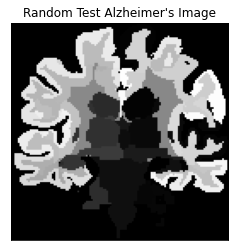

In [9]:
showImage(img_tensor[0], "Random Test Alzheimer's Image")

### Build Model Outputting Conv. Activations

In [10]:
model.input

<tf.Tensor 'vgg16_input:0' shape=(?, 128, 128, 3) dtype=float32>

In [21]:
layer_outputs = [layer.output for layer in model.get_layer("vgg16").layers[1:18]]
activation_model = models.Model(inputs=model.get_layer("vgg16").input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 64)


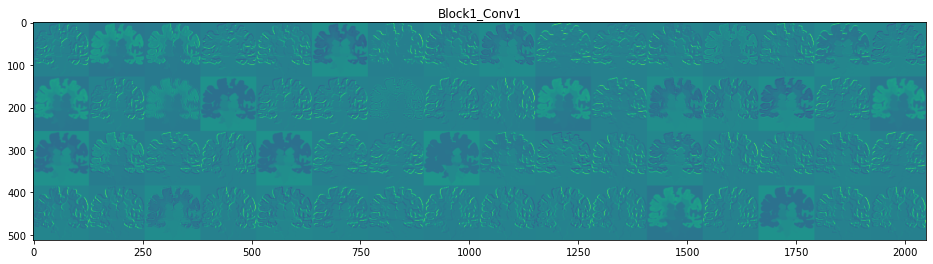

In [29]:
width = 16
height = 4

feature_display = np.zeros((activations[0].shape[1] * height, width * activations[0].shape[1]))

for col in range(height):
    for row in range(width):
        image = activations[0][0, :, :, col * width + row]
        image -= image.mean()
        image /= image.std()
        image *= 64
        image += 128
        
        feature_display[col * activations[0].shape[1] : (col + 1) * activations[0].shape[1],
                      row * activations[0].shape[1] : (row + 1) * activations[0].shape[1]] = image

scale = 1. / activations[0].shape[1]
plt.figure(figsize=(scale * feature_display.shape[1],
                   scale * feature_display.shape[0]))
plt.title("Block1_Conv1")
plt.grid(False)
plt.imshow(feature_display, aspect="auto", cmap="viridis")

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


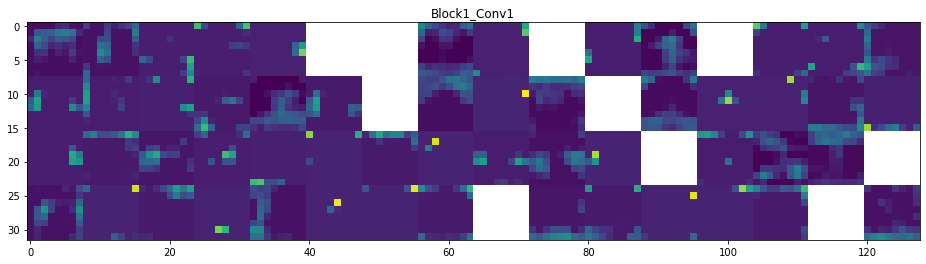

In [31]:
width = 16
height = 4

feature_display = np.zeros((activations[-2].shape[1] * height, width * activations[-2].shape[1]))

for col in range(height):
    for row in range(width):
        image = activations[-2][0, :, :, col * width + row]
        image -= image.mean()
        image /= image.std()
        image *= 64
        image += 128
        
        feature_display[col * activations[-2].shape[1] : (col + 1) * activations[-2].shape[1],
                      row * activations[-2].shape[1] : (row + 1) * activations[-2].shape[1]] = image

scale = 1. / activations[-2].shape[1]
plt.figure(figsize=(scale * feature_display.shape[1],
                   scale * feature_display.shape[0]))
plt.title("Block1_Conv1")
plt.grid(False)
plt.imshow(feature_display, aspect="auto", cmap="viridis")

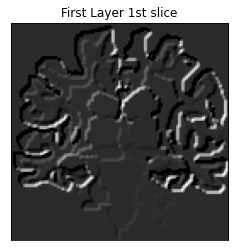

In [18]:
showImage(first_layer_activation[0, :, :, 0], "First Layer 1st slice")